In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
import jax.scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.sparse import csc_matrix
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pyclaude as cl
from pyclaude import observables as obs
from pyclaude import constraints as const

In [3]:
from importlib import reload
reload(obs)
reload(cl)
reload(const)

<module 'pyclaude.constraints' from '/Users/reema/Postdoc/Progetti/MAXENT/pyclaude/pyclaude/constraints.py'>

# Initialize

Here we create some networks with different properties

In [4]:

N = 1000
ba = nx.barabasi_albert_graph(N,30)
gn = nx.scale_free_graph(1000)
bp = nx.bipartite.random_graph(1000,400,0.1)
ba_adj = np.asarray(nx.adj_matrix(ba).todense())
gn_adj = np.sign(np.asarray(nx.adj_matrix(gn).todense()))
bp_adj = np.asarray(nx.adj_matrix(bp).todense())[:1000,1000:]
d = np.array(ba_adj.sum(axis=0)).flatten()
dinv = 1/d

din = np.array(gn_adj.sum(axis=0)).flatten()
dout = np.array(gn_adj.sum(axis=1)).flatten()

bp_din = np.array(bp_adj.sum(axis=0)).flatten()
bp_dout = np.array(bp_adj.sum(axis=1)).flatten()

In [5]:
def plot_adj(adj, vmax=1):
    plt.imshow(adj,cmap=matplotlib.cm.get_cmap('gray_r'),vmin=0,vmax=vmax)
    plt.colorbar()

# Connectivity

In this section we test some constraints on the connectivity of the networks

## Total connectivity

We impose a simple constraint on the total number of edges in the network (connectivity)

In [6]:
# nodenames stores the names of the nodes but it is optional and not used in any way by the package. 
# Its purpose is only to store the ordering of the nodes for when the model is saved and loaded back
m = cl.GraphEnsemble(1000, nodenames=np.arange(1000)) 
m.fit([const.Connectivity(198400)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 9818.44; step 1
1:  |F(x)| = 916.362; step 1
2:  |F(x)| = 51.3878; step 1
3:  |F(x)| = 1.87955; step 1
4:  |F(x)| = 0.0516455; step 1
5:  |F(x)| = 0.00113519; step 1
6:  |F(x)| = 1.71247e-06; step 1
7:  |F(x)| = 2.03727e-10; step 1
8:  |F(x)| = 1.16415e-10; step 1
9:  |F(x)| = 2.91038e-11; step 0.5


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.2446e-19): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.34132e-24): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.1343e-22): result may not be accurate.
  gamma = solve(self.a, df_f)


10:  |F(x)| = 2.91038e-11; step 1
11:  |F(x)| = 1.16415e-10; step 1
12:  |F(x)| = 2.91038e-11; step 1
13:  |F(x)| = 2.91038e-11; step 1
14:  |F(x)| = 1.16415e-10; step 1
15:  |F(x)| = 2.91038e-11; step 1
16:  |F(x)| = 1.16415e-10; step 1
17:  |F(x)| = 2.91038e-11; step 1
18:  |F(x)| = 2.91038e-11; step 1
19:  |F(x)| = 1.16415e-10; step 1
20:  |F(x)| = 1.16415e-10; step 1
21:  |F(x)| = 2.91038e-11; step 0.5
22:  |F(x)| = 2.91038e-11; step 1
23:  |F(x)| = 2.91038e-11; step 1
24:  |F(x)| = 1.16415e-10; step 1
25:  |F(x)| = 2.91038e-11; step 1
26:  |F(x)| = 1.16415e-10; step 1
27:  |F(x)| = 2.91038e-11; step 1
28:  |F(x)| = 2.91038e-11; step 1
29:  |F(x)| = 1.16415e-10; step 1


Now we can define the connectivity itself as an observable we want to observe on the resulting graph ensemble, and predict its average and std.dev.
We also numerically sample the distribution of connectivities we get from the model for comparison

In [7]:
o = obs.Connectivity(sparse=True)
smpl = [np.triu(m.sample(),1).sum() for i in trange(100)]
mean = m.predict_mean(o)
std = m.predict_std(o)

We can now plot the average adjacency matrix as well as compare the sampled connectivities distribution to the predicted values (red)

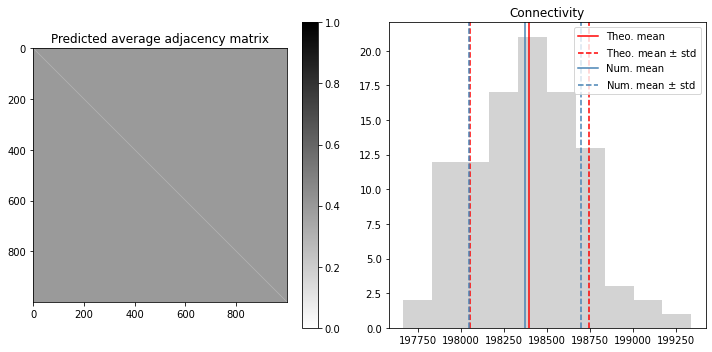

In [19]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_adj(m.adj_matrix)
plt.title('Predicted average adjacency matrix',fontsize=12)
plt.subplot(1,2,2)
plt.hist(smpl,color='lightgray')
plt.axvline(mean,color='red', label='Theo. mean')
plt.axvline(mean-std,color='red',linestyle='dashed', label='Theo. mean $\pm$ std')
plt.axvline(mean+std,color='red',linestyle='dashed')
plt.axvline(np.mean(smpl),color='steelblue', label='Num. mean')
plt.axvline(np.mean(smpl)-np.std(smpl),color='steelblue',linestyle='dashed', label='Num. mean $\pm$ std')
plt.axvline(np.mean(smpl)+np.std(smpl),color='steelblue',linestyle='dashed')
plt.title('Connectivity',fontsize=12)
plt.legend()
plt.tight_layout()

## Subgraph connectivity

Here we impose that only a subset of the nodes has a given connectivity, while leaving the rest of the network unconstrained

In [14]:
nodeset1 = np.arange(300)

In [15]:
m = cl.GraphEnsemble(1000)
m.fit([const.Connectivity(34300, nodeset1=nodeset1)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 17367.3; step 1
1:  |F(x)| = 813.498; step 1
2:  |F(x)| = 176.859; step 1
3:  |F(x)| = 21.4276; step 1
4:  |F(x)| = 1.83365; step 1
5:  |F(x)| = 0.124335; step 1
6:  |F(x)| = 0.00415162; step 1
7:  |F(x)| = 3.48171e-05; step 1
8:  |F(x)| = 5.11573e-08; step 1
9:  |F(x)| = 2.91038e-11; step 1
10:  |F(x)| = 1.45519e-11; step 1
11:  |F(x)| = 7.27596e-12; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.04439e-19): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.59285e-23): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=2.99501e-21): result may not be accurate.
  gamma = solve(self.a, df_f)


12:  |F(x)| = 7.27596e-12; step 1
13:  |F(x)| = 0; step 1


In [18]:
o = obs.Connectivity(nodeset1=nodeset1)
smpl = [np.triu(m.sample()[:300,:300]).sum() for i in trange(100)]
mean = m.predict_mean(o)
std = m.predict_std(o)

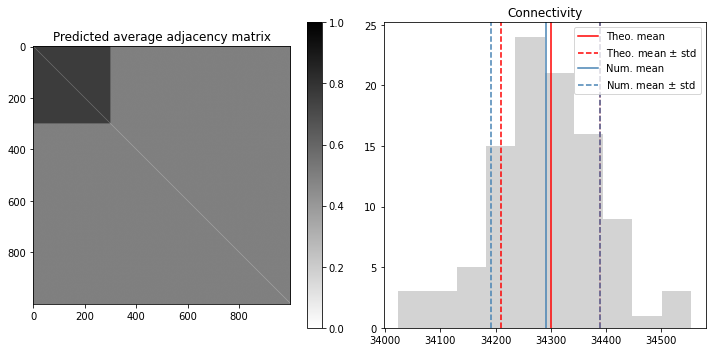

In [19]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_adj(m.adj_matrix)
plt.title('Predicted average adjacency matrix',fontsize=12)
plt.subplot(1,2,2)
plt.hist(smpl,color='lightgray')
plt.axvline(mean,color='red', label='Theo. mean')
plt.axvline(mean-std,color='red',linestyle='dashed', label='Theo. mean $\pm$ std')
plt.axvline(mean+std,color='red',linestyle='dashed')
plt.axvline(np.mean(smpl),color='steelblue', label='Num. mean')
plt.axvline(np.mean(smpl)-np.std(smpl),color='steelblue',linestyle='dashed', label='Num. mean $\pm$ std')
plt.axvline(np.mean(smpl)+np.std(smpl),color='steelblue',linestyle='dashed')
plt.legend()
plt.title('Connectivity',fontsize=12)
plt.tight_layout()

## Connectivity between 2 groups of nodes

Similarly to the example above, we impose that two groups of nodes have a given connectivity, leaving the rest of the network unconstrained

In [21]:
nodeset1 = np.arange(300)
nodeset2 = np.arange(450,700)

In [25]:
m = cl.GraphEnsemble(1000)
m.fit([const.Connectivity(300, nodeset1=nodeset1, nodeset2=nodeset2)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 13381.9; step 1
1:  |F(x)| = 5227.98; step 1
2:  |F(x)| = 3049.27; step 1
3:  |F(x)| = 1860.17; step 1
4:  |F(x)| = 1181.9; step 1
5:  |F(x)| = 770.443; step 1
6:  |F(x)| = 474.442; step 1
7:  |F(x)| = 278.219; step 1
8:  |F(x)| = 154.277; step 1
9:  |F(x)| = 78.5543; step 1
10:  |F(x)| = 35.1165; step 1
11:  |F(x)| = 12.8979; step 1
12:  |F(x)| = 3.55203; step 1
13:  |F(x)| = 0.653723; step 1
14:  |F(x)| = 0.0700334; step 1
15:  |F(x)| = 0.00371426; step 1
16:  |F(x)| = 8.04156e-05; step 1
17:  |F(x)| = 5.60578e-07; step 1
18:  |F(x)| = 9.36438e-10; step 1
19:  |F(x)| = 2.27374e-13; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.02408e-16): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=2.35769e-20): result may not be accurate.
  gamma = solve(self.a, df_f)


20:  |F(x)| = 2.27374e-13; step 1
21:  |F(x)| = 2.27374e-13; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.91476e-24): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.21968e-21): result may not be accurate.
  gamma = solve(self.a, df_f)


22:  |F(x)| = 2.27374e-13; step 1
23:  |F(x)| = 2.27374e-13; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=5.49206e-17): result may not be accurate.
  gamma = solve(self.a, df_f)


24:  |F(x)| = 2.27374e-13; step 1
25:  |F(x)| = 2.27374e-13; step 1
26:  |F(x)| = 2.27374e-13; step 1
27:  |F(x)| = 2.27374e-13; step 1
28:  |F(x)| = 2.27374e-13; step 1
29:  |F(x)| = 2.27374e-13; step 1


In [29]:
o = obs.Connectivity(nodeset1=nodeset1,nodeset2=nodeset2)
smpl = [np.triu(m.sample())[nodeset1[:,None],nodeset2].sum() for i in trange(100)]
mean = m.predict_mean(o)
std = m.predict_std(o)

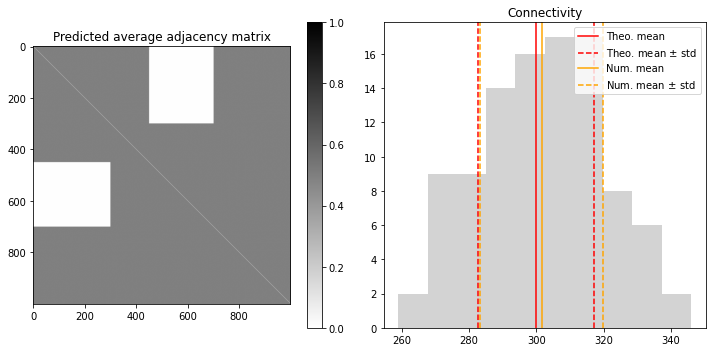

In [30]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_adj(m.adj_matrix)
plt.title('Predicted average adjacency matrix',fontsize=12)
plt.subplot(1,2,2)
plt.hist(smpl,color='lightgray')
plt.axvline(mean,color='red', label='Theo. mean')
plt.axvline(mean-std,color='red',linestyle='dashed', label='Theo. mean $\pm$ std')
plt.axvline(mean+std,color='red',linestyle='dashed')
plt.axvline(np.mean(smpl),color='orange', label='Num. mean')
plt.axvline(np.mean(smpl)-np.std(smpl),color='orange',linestyle='dashed', label='Num. mean $\pm$ std')
plt.axvline(np.mean(smpl)+np.std(smpl),color='orange',linestyle='dashed')
plt.title('Connectivity',fontsize=12)
plt.legend()
plt.tight_layout()

# Fixed degree sequence

Here we impose some constraints on the degree sequence of the network

### Full degree sequence

We impose a constraint on the full degree sequence, and we make it match the degree sequence of one of the networks defined above (BA)

In [7]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

0:  |F(x)| = 98.367; step 1
1:  |F(x)| = 39.4228; step 1
2:  |F(x)| = 45.7638; step 1
3:  |F(x)| = 50.2524; step 1
4:  |F(x)| = 16.7903; step 0.307024
5:  |F(x)| = 26.031; step 1
6:  |F(x)| = 4.06489; step 0.405699
7:  |F(x)| = 2.67241; step 1
8:  |F(x)| = 2.04985; step 1
9:  |F(x)| = 1.30526; step 1
10:  |F(x)| = 0.908004; step 1
11:  |F(x)| = 0.698844; step 1
12:  |F(x)| = 0.504142; step 1
13:  |F(x)| = 0.331493; step 1
14:  |F(x)| = 0.267635; step 1
15:  |F(x)| = 0.178807; step 1
16:  |F(x)| = 0.123712; step 1
17:  |F(x)| = 0.0813704; step 1
18:  |F(x)| = 0.0401193; step 1
19:  |F(x)| = 0.0234994; step 1
20:  |F(x)| = 0.009735; step 1
21:  |F(x)| = 0.0032019; step 1
22:  |F(x)| = 0.000914306; step 1
23:  |F(x)| = 0.00185999; step 1
24:  |F(x)| = 0.00215473; step 1
25:  |F(x)| = 0.00208539; step 1
26:  |F(x)| = 0.0018583; step 1
27:  |F(x)| = 0.00161616; step 1
28:  |F(x)| = 0.00126534; step 1
29:  |F(x)| = 0.00101437; step 1
30:  |F(x)| = 0.000705365; step 1
31:  |F(x)| = 0.00042633

In [8]:
o = obs.DegreeSequence
smpl = np.asarray([m.sample().sum(axis=1) for i in trange(100)])
theo_mean = m.predict_mean(o)
theo_std = m.predict_std(o)
num_mean = smpl.mean(axis=0)
num_std = smpl.std(axis=0)

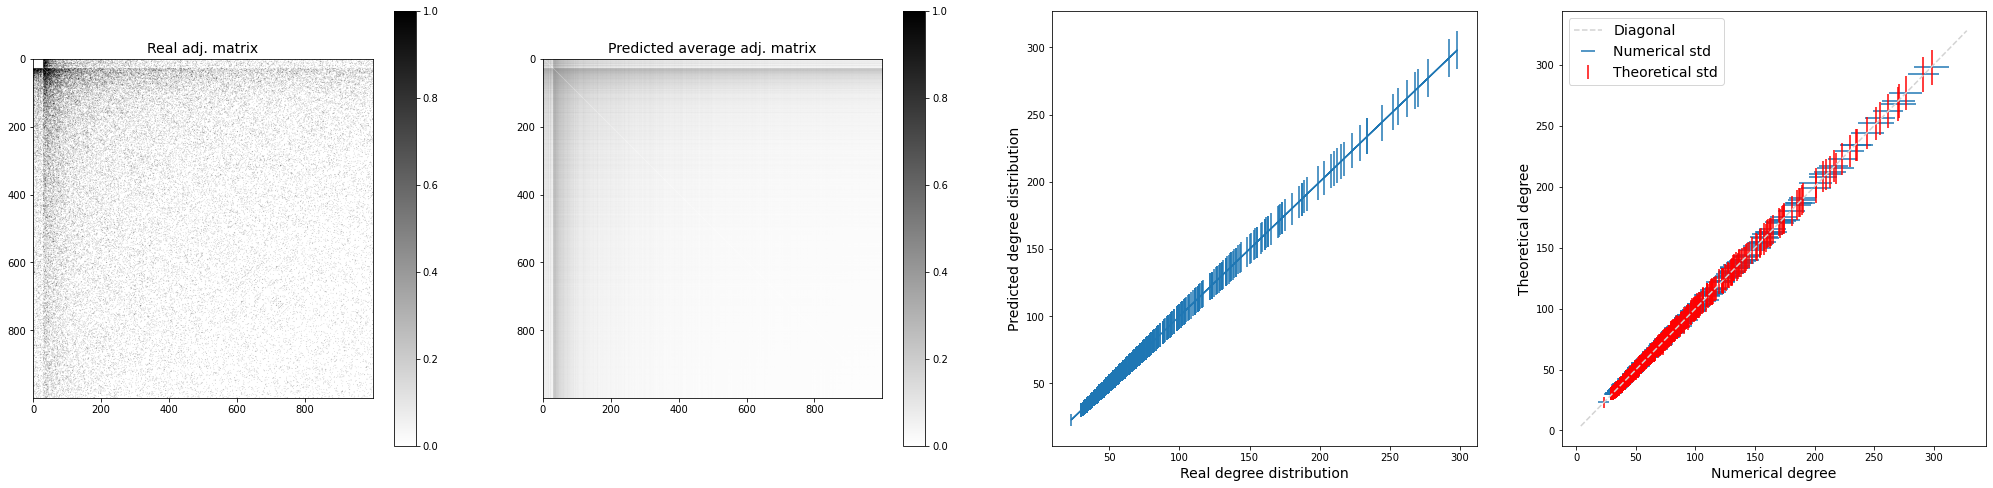

In [9]:
plt.figure(figsize=[35,8])
plt.subplot(1,4,1)
plot_adj(ba_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,4,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adj. matrix',fontsize=14)
plt.subplot(1,4,3)
plt.errorbar(d, theo_mean,yerr=theo_std)
plt.xlabel('Original degree distribution',fontsize=14)
plt.ylabel('Predicted degree distribution',fontsize=14)
plt.subplot(1,4,4)
plt.errorbar(num_mean,theo_mean,xerr=num_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_mean,theo_mean,yerr=theo_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical degree',fontsize=14)
plt.ylabel('Theoretical degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)

### Partial degree sequence

We can also impose that only a subset of nodes have a specified average degree

In [11]:
nodeset=np.arange(500)

In [12]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d[nodeset], nodeset=nodeset)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 99.5757; step 1
1:  |F(x)| = 51.6868; step 1
2:  |F(x)| = 25.4898; step 1
3:  |F(x)| = 39.2356; step 1
4:  |F(x)| = 15.0865; step 1
5:  |F(x)| = 6.62177; step 1
6:  |F(x)| = 6.80633; step 1
7:  |F(x)| = 4.53849; step 1
8:  |F(x)| = 3.02309; step 1
9:  |F(x)| = 2.67885; step 1
10:  |F(x)| = 2.20329; step 1
11:  |F(x)| = 1.49209; step 1
12:  |F(x)| = 0.879468; step 1
13:  |F(x)| = 0.54694; step 1
14:  |F(x)| = 0.376981; step 1
15:  |F(x)| = 0.194804; step 1
16:  |F(x)| = 0.074654; step 1
17:  |F(x)| = 0.032615; step 1
18:  |F(x)| = 0.0309505; step 1
19:  |F(x)| = 0.024184; step 1
20:  |F(x)| = 0.0150589; step 1
21:  |F(x)| = 0.0116442; step 1
22:  |F(x)| = 0.00945302; step 1
23:  |F(x)| = 0.00497393; step 1
24:  |F(x)| = 0.00341961; step 1
25:  |F(x)| = 0.00285345; step 1
26:  |F(x)| = 0.00220544; step 1
27:  |F(x)| = 0.00138778; step 1
28:  |F(x)| = 0.000822251; step 1
29:  |F(x)| = 0.000432845; step 1


In [13]:
o = obs.DegreeSequence
smpl = np.asarray([m.sample().sum(axis=1) for i in trange(100)])
theo_mean = m.predict_mean(o)
theo_std = m.predict_std(o)
num_mean = smpl.mean(axis=0)
num_std = smpl.std(axis=0)

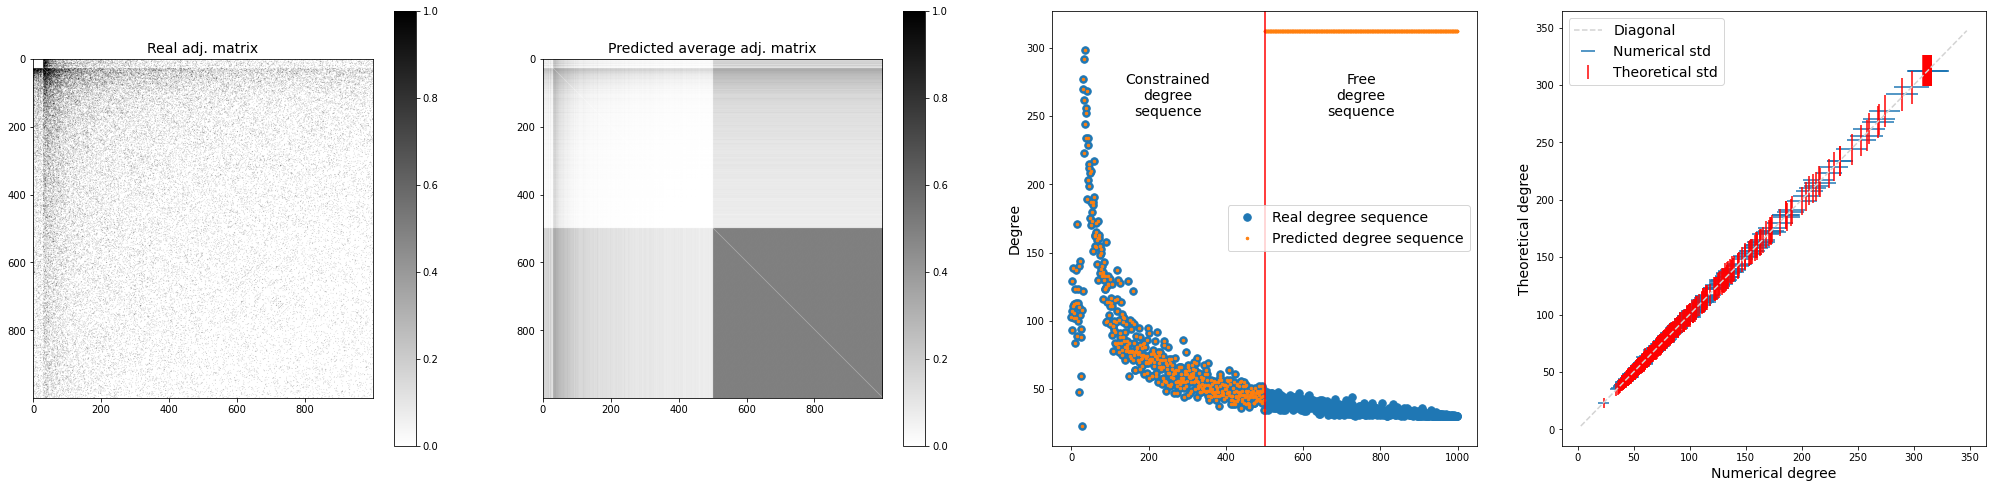

In [15]:
plt.figure(figsize=[35,8])
plt.subplot(1,4,1)
plot_adj(ba_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,4,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adj. matrix',fontsize=14)
plt.subplot(1,4,3)
plt.plot(d, '.', markersize=15,label='Original degree sequence')
plt.plot(theo_mean,'.',markersize=5,label='Predicted degree sequence')
plt.axvline(len(nodeset),color='red')
plt.text(len(nodeset)/2,250,'Constrained\ndegree\nsequence',fontsize=14,ha='center')
plt.text(len(nodeset)*3/2,250,'Free\ndegree\nsequence',fontsize=14,ha='center')
plt.ylabel('Degree',fontsize=14)
plt.legend(fontsize=14)
plt.subplot(1,4,4)
plt.errorbar(num_mean,theo_mean,xerr=num_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_mean,theo_mean,yerr=theo_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical degree',fontsize=14)
plt.ylabel('Theoretical degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)

### Degree sequence in subgraph

Here we impose that a subset of nodes have a specified average degree only within a subgraph, leaving the rest of the edges unconstrained

In [36]:
nodeset = np.arange(200)
bg_nodeset = np.arange(500)
ba_partial_d = ba_adj[nodeset[:,None],bg_nodeset].sum(axis=1)

In [37]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(ba_partial_d, nodeset=nodeset, subgraph_nodeset=bg_nodeset)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

0:  |F(x)| = 35.4211; step 1
1:  |F(x)| = 22.7166; step 1
2:  |F(x)| = 15.455; step 1
3:  |F(x)| = 9.13244; step 1
4:  |F(x)| = 5.44492; step 1
5:  |F(x)| = 3.43512; step 1
6:  |F(x)| = 1.74273; step 1
7:  |F(x)| = 0.48635; step 1
8:  |F(x)| = 0.322453; step 1
9:  |F(x)| = 0.150866; step 1
10:  |F(x)| = 0.0507356; step 1
11:  |F(x)| = 0.0187879; step 1
12:  |F(x)| = 0.00366858; step 1
13:  |F(x)| = 0.00171449; step 1
14:  |F(x)| = 0.00100524; step 1
15:  |F(x)| = 0.000707857; step 1
16:  |F(x)| = 0.000291575; step 1
17:  |F(x)| = 0.000168473; step 1
18:  |F(x)| = 0.000111881; step 1
19:  |F(x)| = 5.93041e-05; step 1
20:  |F(x)| = 1.89493e-05; step 1
21:  |F(x)| = 6.9073e-06; step 1
22:  |F(x)| = 2.70596e-06; step 1
23:  |F(x)| = 1.22721e-06; step 1
24:  |F(x)| = 1.17629e-06; step 1
25:  |F(x)| = 7.38768e-07; step 1
26:  |F(x)| = 3.31074e-07; step 1
27:  |F(x)| = 1.95713e-07; step 1
28:  |F(x)| = 1.11434e-07; step 1
29:  |F(x)| = 4.91927e-08; step 1
30:  |F(x)| = 1.94982e-08; step 1
31:

In [33]:
o = obs.DegreeSequence(nodeset=nodeset,subgraph_nodeset=bg_nodeset)
smpl = np.asarray([m.sample()[nodeset[:,None],bg_nodeset].sum(axis=1) for i in trange(100)])
theo_mean = m.predict_mean(o)
theo_std = m.predict_std(o)
num_mean = smpl.mean(axis=0)
num_std = smpl.std(axis=0)

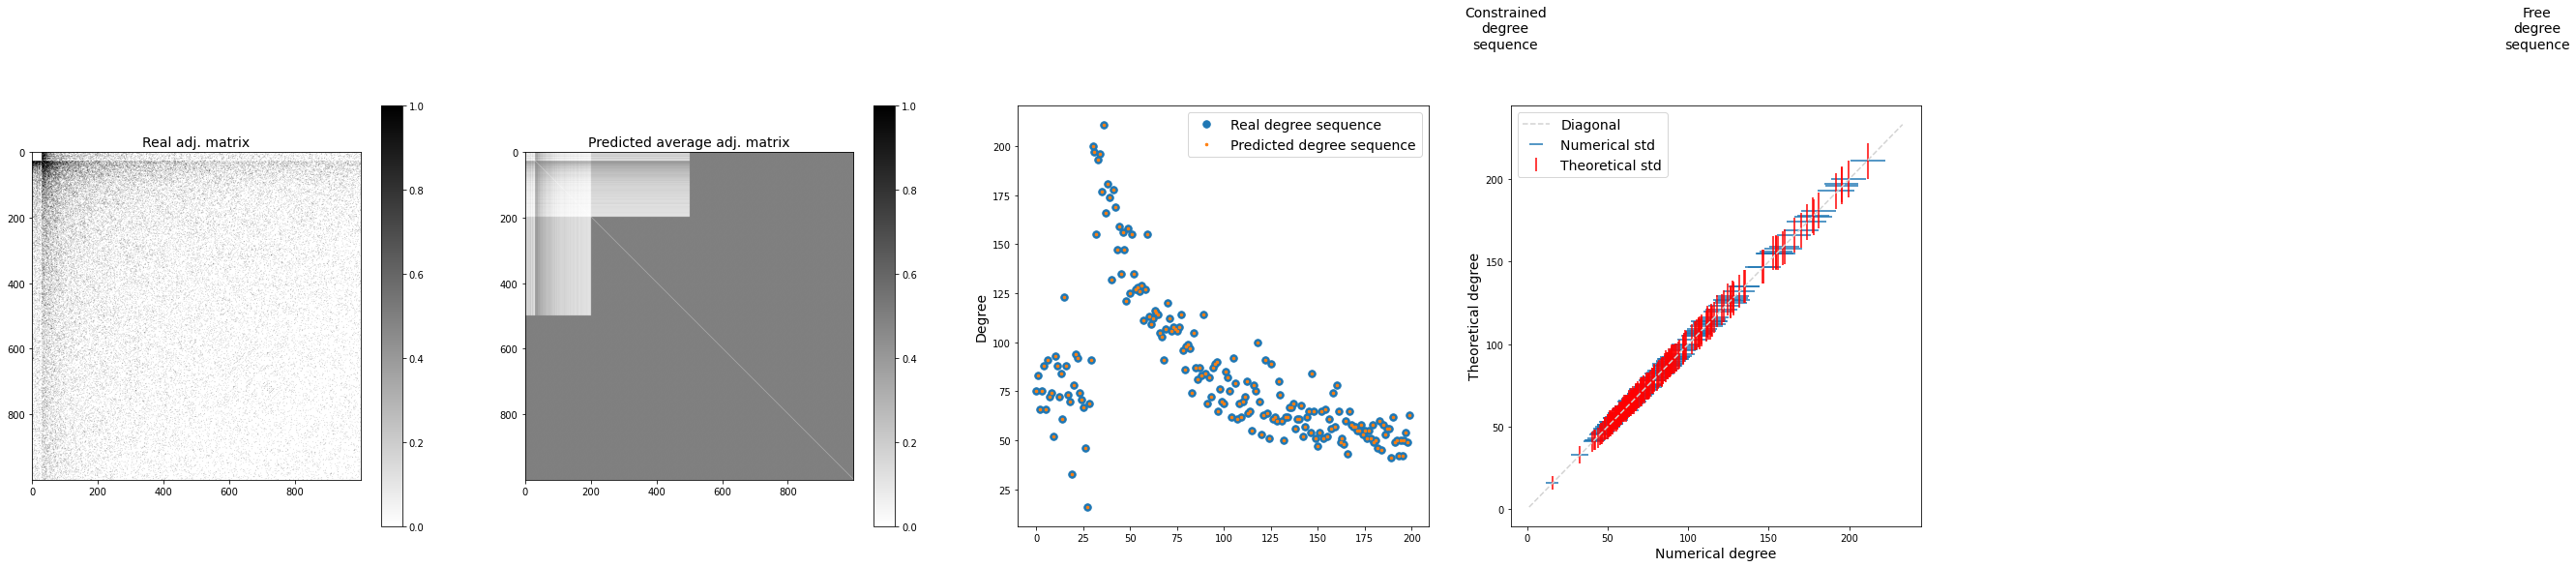

In [38]:
plt.figure(figsize=[35,8])
plt.subplot(1,4,1)
plot_adj(ba_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,4,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adj. matrix',fontsize=14)
plt.subplot(1,4,3)
plt.plot(ba_partial_d, '.', markersize=15,label='Original degree sequence')
plt.plot(theo_mean,'.',markersize=5,label='Predicted degree sequence')
#plt.axvline(200,color='red')
plt.text(250,250,'Constrained\ndegree\nsequence',fontsize=14,ha='center')
plt.text(800,250,'Free\ndegree\nsequence',fontsize=14,ha='center')
plt.ylabel('Degree',fontsize=14)
plt.legend(fontsize=14)
plt.subplot(1,4,4)
plt.errorbar(num_mean,theo_mean,xerr=num_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_mean,theo_mean,yerr=theo_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical degree',fontsize=14)
plt.ylabel('Theoretical degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)

# Fixing edges

In this section we show how to fix the values of edges. Note that in this case the edges will be fixed for every realization and will exactly match the given values. In case of binary network ensemble, these values should be set to either 0 or 1

In [39]:
edges1 = np.asarray(np.meshgrid(np.arange(100),np.arange(100,200))).T.reshape(-1,2)
edges0 = np.asarray(np.meshgrid(np.arange(100,200),np.arange(300,400))).T.reshape(-1,2)

In [40]:
m = cl.GraphEnsemble(1000)
m.fix_edges_value(np.concatenate([edges0,edges1],axis=0), np.concatenate([np.zeros(len(edges0)),np.ones(len(edges1))]))
m.fit([const.Connectivity(150000)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 9328.35; step 0.0362154
1:  |F(x)| = 248.751; step 1
2:  |F(x)| = 8.53801; step 1
3:  |F(x)| = 0.190824; step 1
4:  |F(x)| = 0.00320217; step 1
5:  |F(x)| = 4.2987e-05; step 1
6:  |F(x)| = 1.72673e-07; step 1
7:  |F(x)| = 8.73115e-11; step 1
8:  |F(x)| = 2.91038e-11; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.3903e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.38767e-18): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=4.78292e-20): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=4.42378e-23): result may not be accurate.
  gamma = solve(self.a, df_f)


9:  |F(x)| = 2.91038e-11; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.52703e-20): result may not be accurate.
  gamma = solve(self.a, df_f)


10:  |F(x)| = 2.91038e-11; step 1
11:  |F(x)| = 2.91038e-11; step 1
12:  |F(x)| = 2.91038e-11; step 1
13:  |F(x)| = 2.91038e-11; step 1
14:  |F(x)| = 2.91038e-11; step 1
15:  |F(x)| = 2.91038e-11; step 1
16:  |F(x)| = 2.91038e-11; step 1
17:  |F(x)| = 2.91038e-11; step 1
18:  |F(x)| = 2.91038e-11; step 1
19:  |F(x)| = 2.91038e-11; step 1
20:  |F(x)| = 2.91038e-11; step 1
21:  |F(x)| = 2.91038e-11; step 1
22:  |F(x)| = 2.91038e-11; step 1
23:  |F(x)| = 2.91038e-11; step 1
24:  |F(x)| = 2.91038e-11; step 1
25:  |F(x)| = 2.91038e-11; step 1
26:  |F(x)| = 2.91038e-11; step 1
27:  |F(x)| = 2.91038e-11; step 1
28:  |F(x)| = 2.91038e-11; step 1
29:  |F(x)| = 2.91038e-11; step 1


Text(0.5, 1.0, 'Predicted average adj. matrix')

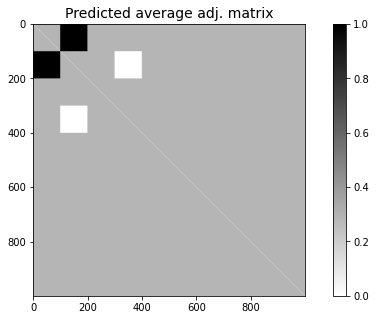

In [43]:
plt.figure(figsize=[10,5])
plot_adj(m.adj_matrix)
plt.title('Predicted average adj. matrix',fontsize=14)

# Joining constraints

In this part we join several constraints together, in order to fit a model that satisfies all the constraints simultaneously. To do this, we provide a list of constraints to the model

In [40]:
nodeset1 = np.arange(200)
nodeset2 = np.arange(300,400)

In [41]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d),const.Connectivity(500, nodeset1=nodeset1, nodeset2=nodeset2)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

0:  |F(x)| = 484.762; step 1
1:  |F(x)| = 445.853; step 1
2:  |F(x)| = 753.316; step 1
3:  |F(x)| = 504.68; step 1
4:  |F(x)| = 24.0621; step 1
5:  |F(x)| = 26.4843; step 0.00258233
6:  |F(x)| = 42.3299; step 0.0405293
7:  |F(x)| = 77.0412; step 0.169508
8:  |F(x)| = 110.245; step 1
9:  |F(x)| = 74.0659; step 1
10:  |F(x)| = 4.64272; step 1
11:  |F(x)| = 2.29362; step 1
12:  |F(x)| = 0.395661; step 1
13:  |F(x)| = 0.509884; step 1
14:  |F(x)| = 0.2344; step 1
15:  |F(x)| = 0.12257; step 1
16:  |F(x)| = 0.0478206; step 1
17:  |F(x)| = 0.0240193; step 1
18:  |F(x)| = 0.0152538; step 1
19:  |F(x)| = 0.0105505; step 1
20:  |F(x)| = 0.00423293; step 1
21:  |F(x)| = 0.00202692; step 1
22:  |F(x)| = 0.00160411; step 1
23:  |F(x)| = 0.00138057; step 1
24:  |F(x)| = 0.000984344; step 1
25:  |F(x)| = 0.000553365; step 1
26:  |F(x)| = 0.000284298; step 1
27:  |F(x)| = 0.000145264; step 1
28:  |F(x)| = 0.00014335; step 1
29:  |F(x)| = 0.000133749; step 1
30:  |F(x)| = 8.45392e-05; step 1
31:  |F(x

In [42]:
o_d = obs.DegreeSequence
theo_mean_d = m.predict_mean(o_d)
theo_std_d = m.predict_std(o_d)

o_c = obs.Connectivity(nodeset1=nodeset1,nodeset2=nodeset2)
smpl = [np.triu(m.sample())[nodeset1[:,None],nodeset2].sum() for i in trange(100)]
theo_mean_c = m.predict_mean(o_c)
theo_std_c = m.predict_std(o_c)

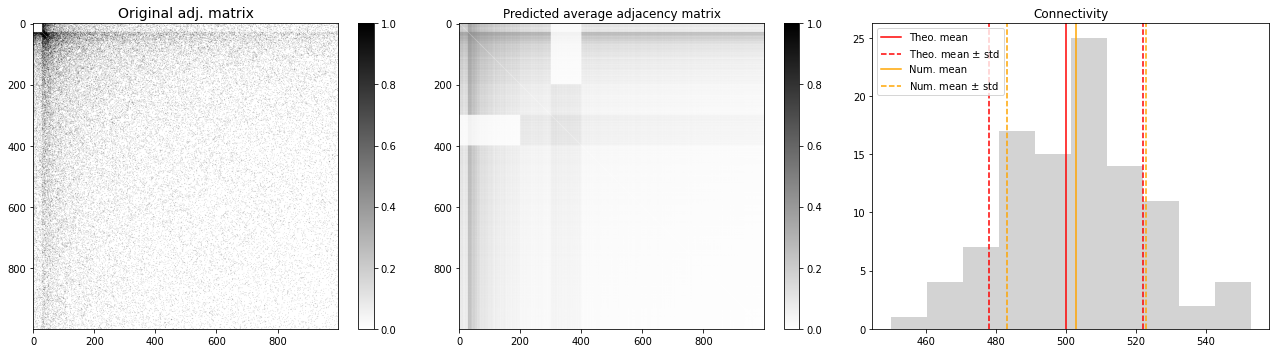

In [43]:
plt.figure(figsize=[18,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adjacency matrix',fontsize=12)
plt.subplot(1,3,3)
plt.hist(smpl,color='lightgray')
plt.axvline(theo_mean_c,color='red', label='Theo. mean')
plt.axvline(theo_mean_c-theo_std_c,color='red',linestyle='dashed', label='Theo. mean $\pm$ std')
plt.axvline(theo_mean_c+theo_std_c,color='red',linestyle='dashed')
plt.axvline(np.mean(smpl),color='orange', label='Num. mean')
plt.axvline(np.mean(smpl)-np.std(smpl),color='orange',linestyle='dashed', label='Num. mean $\pm$ std')
plt.axvline(np.mean(smpl)+np.std(smpl),color='orange',linestyle='dashed')
plt.title('Connectivity',fontsize=12)
plt.legend()
plt.tight_layout()

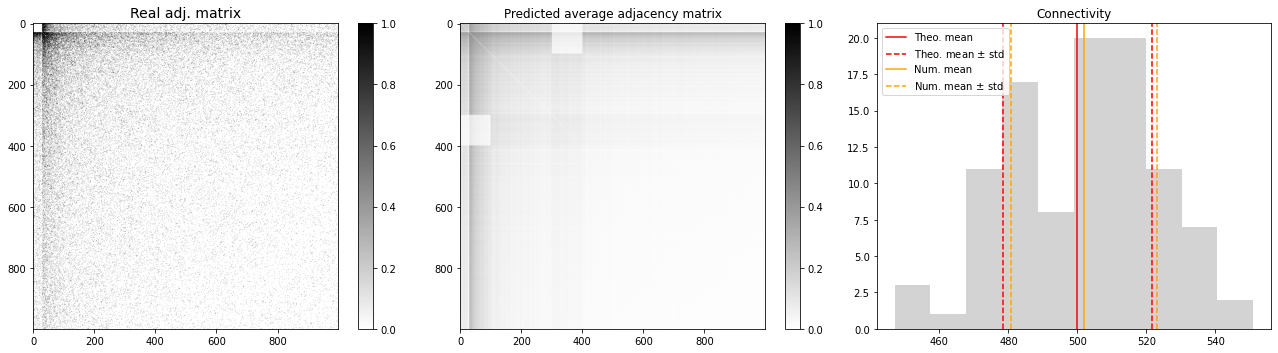

In [82]:
plt.figure(figsize=[18,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adjacency matrix',fontsize=12)
plt.subplot(1,3,3)
plt.hist(smpl,color='lightgray')
plt.axvline(theo_mean_c,color='red', label='Theo. mean')
plt.axvline(theo_mean_c-theo_std_c,color='red',linestyle='dashed', label='Theo. mean $\pm$ std')
plt.axvline(theo_mean_c+theo_std_c,color='red',linestyle='dashed')
plt.axvline(np.mean(smpl),color='orange', label='Num. mean')
plt.axvline(np.mean(smpl)-np.std(smpl),color='orange',linestyle='dashed', label='Num. mean $\pm$ std')
plt.axvline(np.mean(smpl)+np.std(smpl),color='orange',linestyle='dashed')
plt.title('Connectivity',fontsize=12)
plt.legend()
plt.tight_layout()

# Directed networks

Here we test some of the features above on a directed network

In [11]:
m = cl.GraphEnsemble(1000, directed=True)
m.fit([const.OutDegreeSequence(dout),const.InDegreeSequence(din)], opt_kwargs={'nit':150,'fatol':1e-2,'disp':True})

0:  |F(x)| = 211.844; step 1
1:  |F(x)| = 68.1485; step 1
2:  |F(x)| = 53.6929; step 1
3:  |F(x)| = 56.799; step 1
4:  |F(x)| = 97.8181; step 1
5:  |F(x)| = 82.3915; step 1
6:  |F(x)| = 15.0368; step 1
7:  |F(x)| = 16.2578; step 1
8:  |F(x)| = 15.3909; step 1
9:  |F(x)| = 12.7736; step 1
10:  |F(x)| = 14.7386; step 1
11:  |F(x)| = 6.19223; step 1
12:  |F(x)| = 7.42645; step 1
13:  |F(x)| = 8.96566; step 1
14:  |F(x)| = 5.22568; step 1
15:  |F(x)| = 5.10532; step 1
16:  |F(x)| = 4.26572; step 1
17:  |F(x)| = 8.19262; step 1
18:  |F(x)| = 7.73923; step 1
19:  |F(x)| = 5.86838; step 1
20:  |F(x)| = 2.93649; step 1
21:  |F(x)| = 2.10983; step 0.308315
22:  |F(x)| = 3.15867; step 1
23:  |F(x)| = 3.70951; step 1
24:  |F(x)| = 4.04735; step 1
25:  |F(x)| = 2.3254; step 1
26:  |F(x)| = 1.81001; step 1
27:  |F(x)| = 2.22915; step 1
28:  |F(x)| = 2.32368; step 1
29:  |F(x)| = 1.47816; step 1
30:  |F(x)| = 1.5548; step 1
31:  |F(x)| = 1.27705; step 1
32:  |F(x)| = 1.33144; step 1
33:  |F(x)| = 1.

In [12]:
o_out = obs.OutDegreeSequence
smpl = np.asarray([m.sample().sum(axis=1) for i in trange(100)])
theo_dout_mean = m.predict_mean(o_out)
theo_dout_std = m.predict_std(o_out)
num_dout_mean = smpl.mean(axis=0)
num_dout_std = smpl.std(axis=0)

o_in = obs.InDegreeSequence
smpl = np.asarray([m.sample().sum(axis=0) for i in trange(100)])
theo_din_mean = m.predict_mean(o_in)
theo_din_std = m.predict_std(o_in)
num_din_mean = smpl.mean(axis=0)
num_din_std = smpl.std(axis=0)

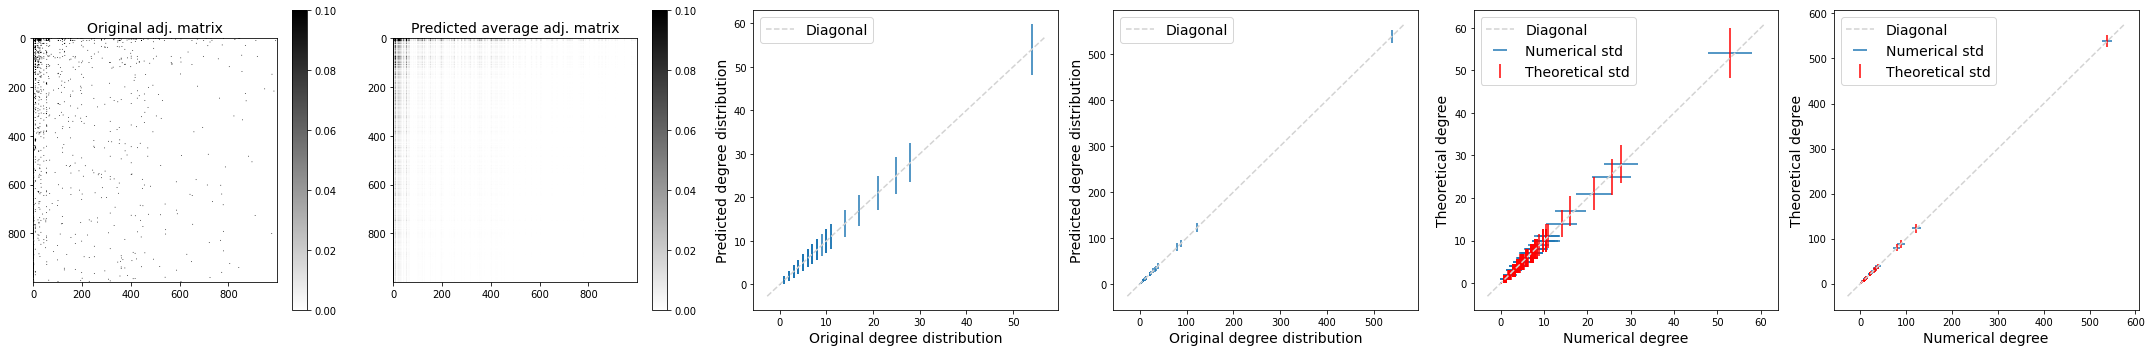

In [13]:
plt.figure(figsize=[30,5])
plt.subplot(1,6,1)
plot_adj(gn_adj, vmax=0.1)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,6,2)
plot_adj(m.adj_matrix, vmax=0.1)
plt.title('Predicted average adj. matrix',fontsize=14)
plt.subplot(1,6,3)
plt.errorbar(dout, theo_dout_mean,yerr=theo_dout_std, linestyle='None')
plt.xlabel('Original out-degree distribution',fontsize=14)
plt.ylabel('Predicted out-degree distribution',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,4)
plt.errorbar(din, theo_din_mean,yerr=theo_din_std, linestyle='None')
plt.xlabel('Original in-degree distribution',fontsize=14)
plt.ylabel('Predicted in-degree distribution',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,5)
plt.errorbar(num_dout_mean,theo_dout_mean,xerr=num_dout_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_dout_mean,theo_dout_mean,yerr=theo_dout_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical out-degree',fontsize=14)
plt.ylabel('Theoretical out-degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,6)
plt.errorbar(num_din_mean,theo_din_mean,xerr=num_din_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_din_mean,theo_din_mean,yerr=theo_din_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical in-degree',fontsize=14)
plt.ylabel('Theoretical in-degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.tight_layout()

# Bipartite networks

Here we test some of the features above on a bipartite network

In [19]:
m = cl.BipartiteGraphEnsemble(1000,400)
m.fit([const.BipartiteOutDegreeSequence(bp_dout),const.BipartiteInDegreeSequence(bp_din)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

0:  |F(x)| = 26.5637; step 0.103801
1:  |F(x)| = 33.1316; step 1
2:  |F(x)| = 29.9832; step 1
3:  |F(x)| = 6.03659; step 1
4:  |F(x)| = 6.06286; step 1
5:  |F(x)| = 1.71445; step 1
6:  |F(x)| = 1.29407; step 1
7:  |F(x)| = 0.853042; step 1
8:  |F(x)| = 0.322515; step 1
9:  |F(x)| = 0.0759103; step 1
10:  |F(x)| = 0.0506729; step 1
11:  |F(x)| = 0.0542133; step 1
12:  |F(x)| = 0.0249881; step 1
13:  |F(x)| = 0.00353615; step 1
14:  |F(x)| = 0.0073262; step 1
15:  |F(x)| = 0.00320021; step 1
16:  |F(x)| = 0.00126322; step 1
17:  |F(x)| = 0.000451363; step 1
18:  |F(x)| = 0.000626907; step 1
19:  |F(x)| = 0.000433264; step 1
20:  |F(x)| = 0.000149243; step 1
21:  |F(x)| = 5.98528e-05; step 1
22:  |F(x)| = 6.40881e-05; step 1
23:  |F(x)| = 3.71089e-05; step 1
24:  |F(x)| = 7.25185e-06; step 1
25:  |F(x)| = 4.74164e-06; step 0.339911
26:  |F(x)| = 6.84706e-06; step 1
27:  |F(x)| = 4.55995e-06; step 1
28:  |F(x)| = 2.11118e-06; step 1
29:  |F(x)| = 1.05601e-06; step 1
30:  |F(x)| = 8.54938e-

In [22]:
o_out = obs.OutDegreeSequence
smpl = np.asarray([m.sample().sum(axis=1) for i in trange(100)])
theo_dout_mean = m.predict_mean(o_out)
theo_dout_std = m.predict_std(o_out)
num_dout_mean = smpl.mean(axis=0)
num_dout_std = smpl.std(axis=0)

o_in = obs.InDegreeSequence
smpl = np.asarray([m.sample().sum(axis=0) for i in trange(100)])
theo_din_mean = m.predict_mean(o_in)
theo_din_std = m.predict_std(o_in)
num_din_mean = smpl.mean(axis=0)
num_din_std = smpl.std(axis=0)

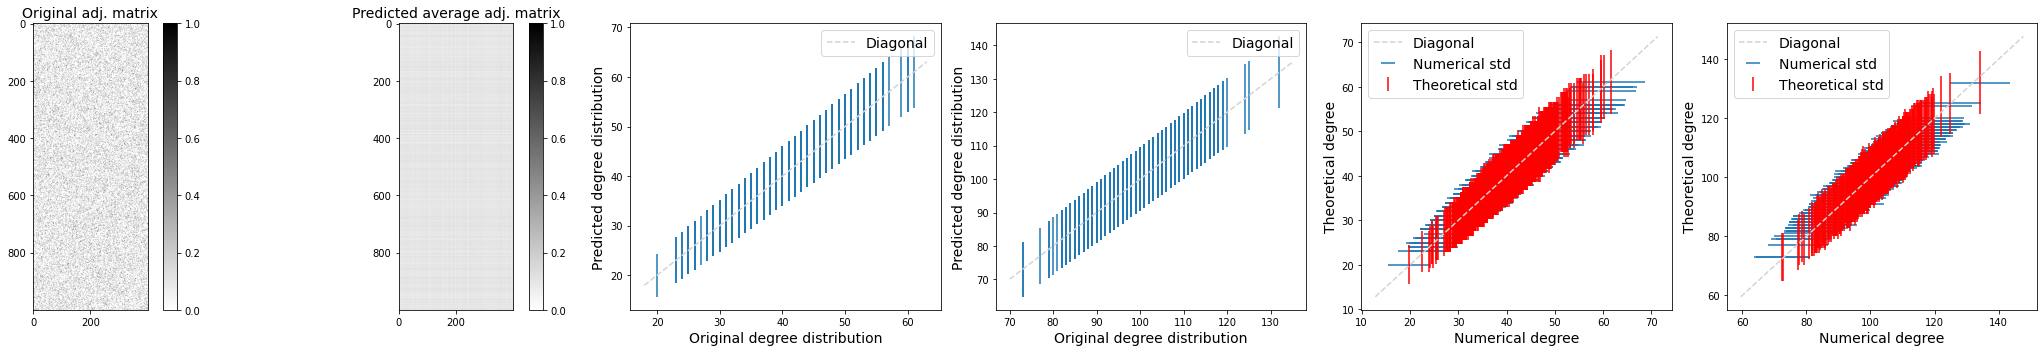

In [34]:
plt.figure(figsize=[30,5])
plt.subplot(1,6,1)
plot_adj(bp_adj)
plt.title('Original adj. matrix',fontsize=14)
plt.subplot(1,6,2)
plot_adj(m.adj_matrix)
plt.title('Predicted average adj. matrix',fontsize=14)
plt.subplot(1,6,3)
plt.errorbar(bp_dout, theo_dout_mean,yerr=theo_dout_std, linestyle='None')
plt.xlabel('Original degree distribution',fontsize=14)
plt.ylabel('Predicted degree distribution',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,4)
plt.errorbar(bp_din, theo_din_mean,yerr=theo_din_std, linestyle='None')
plt.xlabel('Original degree distribution',fontsize=14)
plt.ylabel('Predicted degree distribution',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,5)
plt.errorbar(num_dout_mean,theo_dout_mean,xerr=num_dout_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_dout_mean,theo_dout_mean,yerr=theo_dout_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical degree',fontsize=14)
plt.ylabel('Theoretical degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.subplot(1,6,6)
plt.errorbar(num_din_mean,theo_din_mean,xerr=num_din_std,linestyle = 'None',label='Numerical std')
plt.errorbar(num_din_mean,theo_din_mean,yerr=theo_din_std,linestyle = 'None',color='red',label='Theoretical std')
plt.xlabel('Numerical degree',fontsize=14)
plt.ylabel('Theoretical degree',fontsize=14)
plt.plot(plt.xlim(),plt.xlim(),'--',color='lightgray',label='Diagonal')
plt.legend(fontsize=14)
plt.tight_layout()

# Observables

In this section, we show how to calculate some observables out of the ensembles we fitted

### RWR

Here we calculate the random walk with restart, starting from a subset of 20% nodes in the network

In [117]:
x = np.zeros(N)
x[np.random.randint(0,N, int(N/100*20))] = 1
#x = np.random.rand(N)
x= x/x.sum()
x = np.asarray(x)
lambd = 0.3

In [118]:
def propagate(adj,x,lambd):
    p = adj / np.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = np.eye(p.shape[0])
    return lambd*x.dot(np.linalg.inv(I - (1-lambd)*p))

In [119]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d),const.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':50,'fatol':1e-2,'disp':True})

0:  |F(x)| = 215.29; step 1
1:  |F(x)| = 180.475; step 1
2:  |F(x)| = 74.6861; step 1
3:  |F(x)| = 64.4829; step 1
4:  |F(x)| = 26.6388; step 1
5:  |F(x)| = 10.9457; step 1
6:  |F(x)| = 10.2879; step 1
7:  |F(x)| = 4.86518; step 1
8:  |F(x)| = 3.87894; step 1
9:  |F(x)| = 3.1111; step 1
10:  |F(x)| = 2.36211; step 1
11:  |F(x)| = 1.92251; step 1
12:  |F(x)| = 1.37895; step 1
13:  |F(x)| = 0.961405; step 1
14:  |F(x)| = 0.705619; step 1
15:  |F(x)| = 0.481579; step 1
16:  |F(x)| = 0.269148; step 1
17:  |F(x)| = 0.094001; step 1
18:  |F(x)| = 0.036836; step 1
19:  |F(x)| = 0.0347398; step 1
20:  |F(x)| = 0.0234311; step 1
21:  |F(x)| = 0.0154952; step 1
22:  |F(x)| = 0.0141152; step 1
23:  |F(x)| = 0.0137432; step 1
24:  |F(x)| = 0.0116325; step 1
25:  |F(x)| = 0.00958781; step 1
26:  |F(x)| = 0.00764707; step 1
27:  |F(x)| = 0.00537208; step 1
28:  |F(x)| = 0.00318602; step 1
29:  |F(x)| = 0.00173046; step 1
30:  |F(x)| = 0.000936165; step 1
31:  |F(x)| = 0.000718378; step 1
32:  |F(x)|

In [121]:
k = obs.RandomWalkWithRestart.eval_transfer_matrix(ba_adj, lambd)
kge = obs.RandomWalkWithRestart.eval_transfer_matrix(m.adj_matrix, lambd)

In [123]:
o = obs.RandomWalkWithRestart(x, lambd, mode='exact')
theo_mean = m.predict_mean(o)
theo_std = m.predict_std(o)
y = propagate(ba_adj, x, lambd) # RWR scores on original network
theo_z = m.predict_zscore(y, o)

In [126]:
N_samples = 100
rdmy_ms = np.zeros([len(ba),N_samples])
for i in trange(N_samples):
    flag = False
    while not flag:
        smpl = m.sample()
        prop = propagate(smpl,x,lambd)
        if np.isnan(propagate(smpl,x,lambd)).sum() == 0:
            rdmy_ms[:,i] = propagate(smpl, x,lambd)
            flag = True
    
num_z = (y - rdmy_ms.mean(axis=1))/rdmy_ms.std(axis=1)

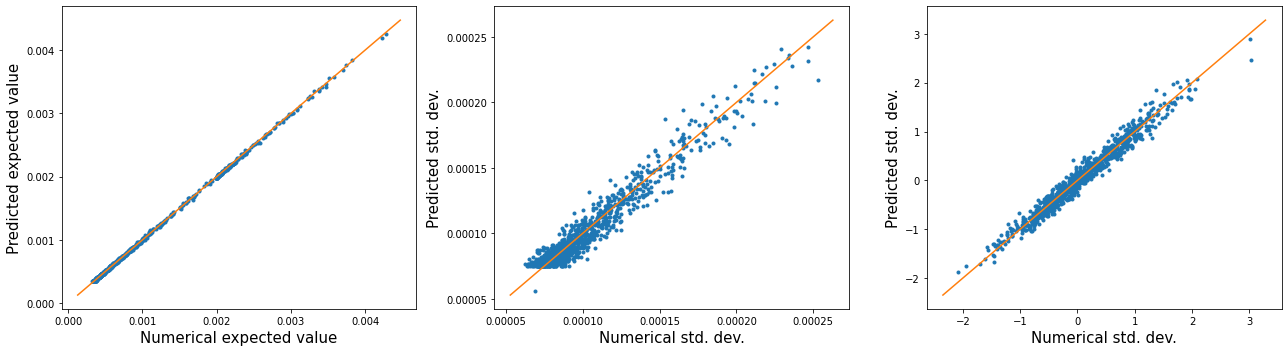

In [129]:
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(rdmy_ms.mean(axis=1),theo_mean,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(132)
plt.plot(rdmy_ms.std(axis=1),theo_std,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(133)
plt.plot(num_z,theo_z,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

### ANND

In [415]:
mu = m.predict_mean(obs.AverageNeighborDegree.func)

In [416]:
sigma = [m.predict_std(grad(obs.AverageNeighborDegree.func, argnums=0), f_args=[i]) for i in trange(N)]

In [417]:
annd = obs.AverageNeighborDegree.func
N_samples = 100
y = np.asarray(annd(csc_matrix(adj))).flatten()
#samples = []
rdm_annd = np.zeros([N,N_samples])
for i in trange(N_samples):
    smpl = csc_matrix(m.sample())
    prop = np.asarray(annd(smpl)).flatten()
    rdm_annd[:,i] = prop
    
z = (y - rdm_annd.mean(axis=1))/rdm_annd.std(axis=1)

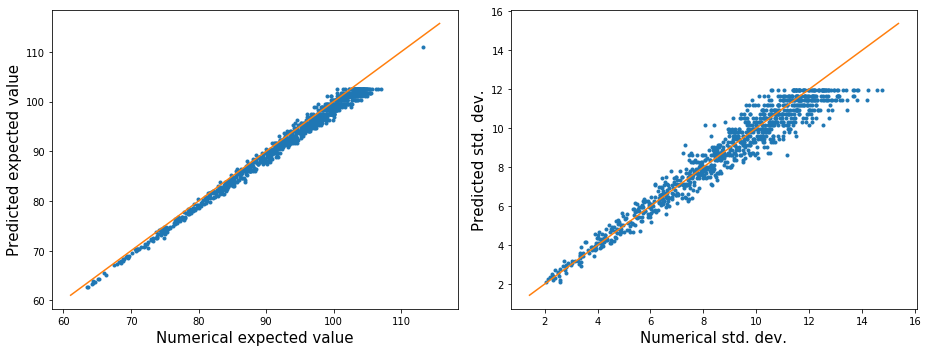

In [418]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdm_annd.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdm_annd.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

# Save and load ensemble

In [ ]:
cl.save_ensemble(m,'')

In [ ]:
m = cl.load_ensemble('')